## Simplified graph with sequence of locks
In this notebook, we set up a basic simulation where a vessel moves over a 1D network path that contains sequence of locks. 

We take the following steps:

1. [Imports](#1.-Imports)
    * [Initialise environment](#Initialise-environment)
2. [Create vessel](#2.-Create-vessel)
3. [Create graph](#3.-Create-graph)
    * [Add hydrodynamic data](#3.1.-Add-hydrodynamic-data)
    * [Add lock](#3.2.-Add-lock)
4. [Run simulation](#4.-Run-simulation)
5. [Inspect output](#5.-Inspect-output)

### 1. Imports
We start with importing required libraries

In [14]:
import networkx as nx
from shapely.geometry import Point,LineString,Polygon

import datetime
import simpy

from opentnsim import core as core_module
from opentnsim import graph as graph_module
from opentnsim import lock as lock_module
from opentnsim import output as output_module
from opentnsim import vessel as vessel_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module

import pandas as pd

import matplotlib.pyplot as plt

#### Initialise environment
For later convenience we already initialise a simpy environment, with some additional properties related to the simulation start and stop time.

In [15]:
t_start = datetime.datetime(2024, 1, 1, 0, 0, 0)

env = simpy.Environment(initial_time=t_start.timestamp())

env.epoch = t_start
env.simulation_start = t_start

### 2. Create vessel
We start with creating a vessel class. We call this class a *Vessel*, and add a number of OpenTNSim mix-ins to this class. Each mix-in requires certain input parameters. We wrap the creation of the vessel class in a function, to facilitate the generation of multiple vessels. 

The following mix-ins are sufficient to create a vessel for our problem: 
* _Identifiable_ - allows to give the vessel a name and a random ID, 
* _SimpyObject_ -
* _HasLock_ - the lock chamber where vessels stay during the leveling process
* _HasLineUpArea_ - a place just in front of the lock to guide vessels entering the lock chamber
* _HasWaitingArea_ - a place where vessels can wait before entering the lock
* _VesselProperties_ - allows the specification of vessel properties, such as L, B and T
* _ExtraMetadata_ -
* _HasOutput_ -

In [16]:
#We create a type element that schematisizes a vessel
def create_vessel(env, name, origin, destination, vessel_type, L, B, T, H, v, arrival_time):
    Vessel = type('Vessel',(core_module.Identifiable,       #The vessel should be identifiable
                            core_module.SimpyObject,        #It should be a simpy element
                            lock_module.HasLock,            #The vessel should interact with a lock chamber
                            lock_module.HasLineUpArea,      #The vessel should interact with a line-up area
                            lock_module.HasWaitingArea,     #The vessel should interact with a waiting area
                            vessel_module.VesselProperties, #The vessel should have properties
                            vessel_module.ExtraMetadata,    #The vessel can have extra metadata
                            output_module.HasOutput,        #The vessel should have output
                           ),{})    

    node = env.FG.nodes[origin]
    geometry = node["geometry"]
    
    vessel = Vessel(
        **{
            "env": env,
            "name": name,
            "origin": origin,
            "destination": destination,
            "geometry": geometry,
            "node": origin,
            "route": nx.dijkstra_path(env.FG, origin, destination),
            "type": vessel_type,
            "L": L,
            "B": B,
            "T": T,
            "H": H,
            "v": v,
            "arrival_time": arrival_time,
        }
    )

    env.process(vessel.move())
    
    return vessel

### 3. Create graph
Next we create a 1D network (a graph) along which the vessel can move. A graph is made of nodes (blue dots in the plot below) and edges (red arrows between the nodes in the plot below). We use the python package networkx to do this. 

In [17]:
# specifiy nodes and edges
node_A = graph_module.Node(name='A',geometry=Point(0,0))
node_B = graph_module.Node(name='B',geometry=Point(400,0))
node_C = graph_module.Node(name='C',geometry=Point(1600,0))
node_D = graph_module.Node(name='D',geometry=Point(2000,0))
edges = [(node_A,node_B),(node_B,node_C),(node_C,node_D)]

# create a graph object
FG = graph_module.DiGraph(edges=edges,crs='EPSG:28992').graph
env.FG = nx.MultiDiGraph(FG)

# add a VTS to the environment to know where vessels are going
env.vessel_traffic_service = vessel_traffic_service_module.VesselTrafficService()

In [18]:
# collect node positions and labels
nodes = []
coordinates = []
labels = {}

for node in env.FG.nodes:
    nodes.append(node)
    coordinates.append([nx.get_node_attributes(env.FG, 'geometry')[node].x, nx.get_node_attributes(env.FG, 'geometry')[node].y])
    labels[node] = node
    
positions = dict(zip(nodes, coordinates))

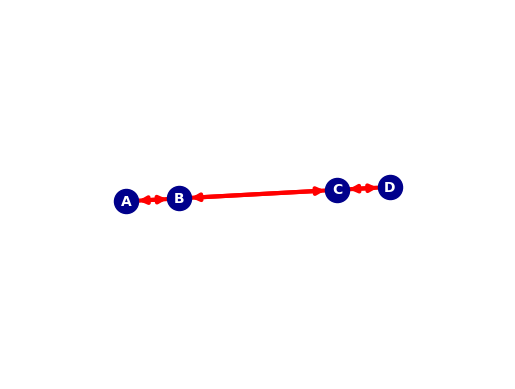

In [19]:
# draw edges, nodes and labels
nx.draw_networkx_edges(env.FG, pos=positions, width=3, edge_color="red", alpha=1, arrowsize=10)
nx.draw_networkx_nodes(env.FG, pos=positions, node_color="darkblue", node_size=300)
nx.draw_networkx_labels(env.FG, pos=positions, labels=labels, font_size=10, font_weight="bold", font_color="white")

plt.axis("off")
plt.show()

Now we need to create the lock infrastructure

In [20]:
# we add two locks to specified edges in the network
lock_I = lock_module.IsLockComplex(env=env,
                                   name='Lock I',
                                   start_node='A',
                                   node_open='A',
                                   end_node='B',
                                   lock_length = 120,
                                   lock_width = 18,
                                   lock_depth = 6,
                                   lineup_area_A_length=120,
                                   lineup_area_B_length=120,
                                   effective_lineup_area_B_length=120,
                                   levelling_time=1500,
                                   distance_doors_A_from_waiting_area_A=140,
                                   distance_doors_B_from_waiting_area_B=140,
                                   distance_waiting_area_A_from_start_node=0,
                                   distance_waiting_area_B_from_end_node=0,
                                   distance_lineup_area_A_to_lock_doors_A=20,
                                   distance_lineup_area_B_to_lock_doors_B=0)

lock_II = lock_module.IsLockComplex(env=env,
                                    name='Lock II',
                                    start_node='C',
                                    node_open='D',
                                    end_node='D',
                                    lock_length = 120,
                                    lock_width = 18,
                                    lock_depth = 6,
                                    lineup_area_A_length=120,
                                    lineup_area_B_length=120,
                                    levelling_time=1500,
                                    distance_doors_A_from_waiting_area_A=140,
                                    distance_doors_B_from_waiting_area_B=140,
                                    distance_waiting_area_A_from_start_node=0,
                                    distance_waiting_area_B_from_end_node=0,
                                    distance_lineup_area_A_to_lock_doors_A=0,
                                    distance_lineup_area_B_to_lock_doors_B=20)

#### 4. Run simulation
We use the _create_vessel_ method to generate two vessels and run the simulation

In [21]:
vessel_1 = create_vessel(env, 'Vessel_1', 'A', 'D', 'inland vessel', 100, 15, 5, 4, 3, datetime.datetime(2024, 1, 1, 0, 0, 0))
vessel_2 = create_vessel(env, 'Vessel_2', 'D', 'A', 'inland vessel', 100, 15, 5, 4, 3, datetime.datetime(2024, 1, 1, 0, 10, 0))
vessels=[vessel_1, vessel_2]

In [22]:
env.run()

#### 5. Inspect results

In [23]:
vessel_1_df = pd.DataFrame(vessel_1.log)
vessel_2_df = pd.DataFrame(vessel_2.log)

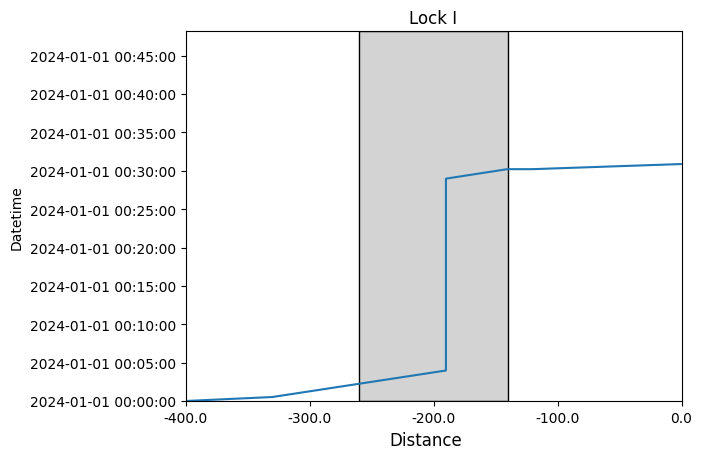

In [31]:
fig, axes = plt.subplots(1,1)
ylim = (min(vessel_1_df.Time.min(), vessel_2_df.Time.min()),max(vessel_1_df.Time.max(), vessel_2_df.Time.max()))

lock_I.create_time_distance_diagram(vessels,ax=axes,x_offset=-200,accuracy=200,ylim=ylim)

axes.set_xlabel('')
axes.set_xlabel('')
axes.set_title('Lock I')

ylim = (min(vessel_1_df.Time.min(), vessel_2_df.Time.min()),max(vessel_1_df.Time.max(), vessel_2_df.Time.max()))

fig.supxlabel('Distance');

In [27]:
lock_df = pd.DataFrame(lock_I.log)
lock_df

,Time,Location,Action,Status
0,2024-01-01 00:03:58.518518,A,Lock doors closing start,{'visiting_vessels': [<__main__.Vessel object ...
1,2024-01-01 00:03:58.518518,A,Lock doors closing stop,{'visiting_vessels': [<__main__.Vessel object ...
2,2024-01-01 00:03:58.518518,A,Lock chamber converting start,{'visiting_vessels': [<__main__.Vessel object ...
3,2024-01-01 00:28:58.518518,B,Lock chamber converting stop,{'visiting_vessels': [<__main__.Vessel object ...
4,2024-01-01 00:28:58.518518,B,Lock doors opening start,{'visiting_vessels': [<__main__.Vessel object ...
5,2024-01-01 00:28:58.518518,B,Lock doors opening stop,{'visiting_vessels': [<__main__.Vessel object ...


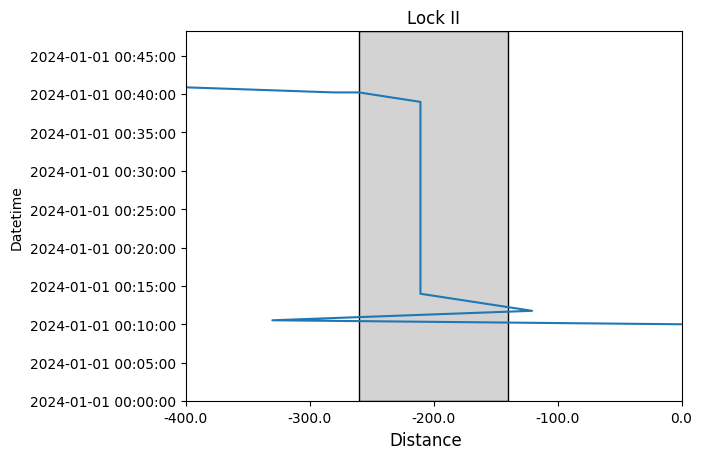

In [32]:
fig, axes = plt.subplots(1,1)
ylim = (min(vessel_1_df.Time.min(), vessel_2_df.Time.min()),max(vessel_1_df.Time.max(), vessel_2_df.Time.max()))

lock_II.create_time_distance_diagram(vessels,ax=axes,x_offset=-200,accuracy=200,ylim=ylim)

axes.set_xlabel('')
axes.set_xlabel('')
axes.set_title('Lock II')

ylim = (min(vessel_1_df.Time.min(), vessel_2_df.Time.min()),max(vessel_1_df.Time.max(), vessel_2_df.Time.max()))

fig.supxlabel('Distance');

In [28]:
lock_df = pd.DataFrame(lock_II.log)
lock_df

,Time,Location,Action,Status
0,2024-01-01 00:13:58.518518,D,Lock doors closing start,{'visiting_vessels': [<__main__.Vessel object ...
1,2024-01-01 00:13:58.518518,D,Lock doors closing stop,{'visiting_vessels': [<__main__.Vessel object ...
2,2024-01-01 00:13:58.518518,D,Lock chamber converting start,{'visiting_vessels': [<__main__.Vessel object ...
3,2024-01-01 00:38:58.518518,C,Lock chamber converting stop,{'visiting_vessels': [<__main__.Vessel object ...
4,2024-01-01 00:38:58.518518,C,Lock doors opening start,{'visiting_vessels': [<__main__.Vessel object ...
5,2024-01-01 00:38:58.518518,C,Lock doors opening stop,{'visiting_vessels': [<__main__.Vessel object ...
